In [31]:
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBList
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

In [91]:
pdbid = '1l0s'#'2q4g'
chain = 'A'
repeats = "3-19,20-34,35-49,50-66"#"2-30,31-58,59-87,88-115,116-144,145-172,173-201,202-229,230-258,259-286,287-315,316-343,344-372,373-400,401-429,430-455"
repeats = repeats.split(',')
repeats = [[int(idx.split('-')[0]), int(idx.split('-')[1])] for idx in repeats]
path = '/home/bio'
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdbid, pdir=path, file_format='pdb')
structure = PDBParser(QUIET=True).get_structure(pdbid, path + "/pdb/{}.pdb".format(pdbid))

Desired structure doesn't exist


In [92]:
selected_chain = structure[0][chain]
selected_residues = [res for res in selected_chain if res.id[0] == " "] # Exclude hetero groups and solvent
#selected_atoms = [atom for residue in selected_residues for atom in residue.get_atoms()]

In [83]:
sup = SVDSuperimposer()


In [93]:
CA_pos = []
for res in selected_residues:
    CA_pos.append(list(res['CA'].get_vector()))
CA_pos = np.array(CA_pos)
CA_pos

array([[16.17000008, 54.2820015 , 42.93700027],
       [18.64999962, 55.43700027, 40.32600021],
       [17.18300056, 56.23300171, 36.90499878],
       [19.92000008, 55.4980011 , 34.38899994],
       [19.73399925, 56.2519989 , 30.67200089],
       [22.99699974, 55.76499939, 28.76099968],
       [25.06100082, 56.52999878, 31.86000061],
       [28.03100014, 54.85100174, 33.5       ],
       [29.16699982, 55.06499863, 37.10699844],
       [32.34700012, 53.90000153, 38.79499817],
       [31.78000069, 50.67499924, 40.73400116],
       [32.61500168, 52.76699829, 43.80500031],
       [30.03300095, 55.5379982 , 43.20899963],
       [26.65200043, 55.90599823, 44.92100143],
       [23.39800072, 56.97600174, 43.23400116],
       [20.20800018, 57.51100159, 45.20800018],
       [16.86000061, 59.01300049, 44.12400055],
       [18.50099945, 60.49599838, 41.06600189],
       [18.39100075, 60.55199814, 37.29499817],
       [21.40699959, 60.01699829, 35.0320015 ],
       [21.11800003, 60.7859993 , 31.332

Basic proof of concept for getting the translation matricies that super-imposes one unit onto the next.\
TODO: Probably explore using vinilla SVD from scipy to get all of the principal vectors so the torsion angles can be calculated according to this paper;
https://onlinelibrary.wiley.com/doi/10.1002/jcc.20237 \
also SVD could be unstable if two principal directions have similar magnitude leading to axes being permutated. this would need to be investigated if this is actually a problem, or if another method of getting unit orientation needs to be worked out.
more info on calculating torsion angles;
https://www.youtube.com/watch?v=NSU0OnW9yLk \ 

here is  blog detailing the re-implementation of the SVD-superimposer (very simple)

https://ideasbyjin.github.io/post/2019-10-06-rmsd/


In [94]:
def get_rot_tran(coord_true, coord_pred):
    """
    Given two matrices, return a rotation and translation matrix to move
    pred coords onto true coords.
    Largely based on SVDSuperimposer implementation from BioPython with some tweaks.
    """
    centroid_pred = np.sum(coord_pred, axis=0) / coord_pred.shape[0]
    centroid_true = np.sum(coord_true, axis=0) / coord_true.shape[0]
    
    p_prime = coord_pred - centroid_pred
    q_prime = coord_true - centroid_true
    
    W = np.dot(q_prime.T, p_prime)
    U, S, Vt = np.linalg.svd(W)
    
    V = Vt.T
    
    rot = np.dot(V, U.T)
    det = np.linalg.det(rot)
    
    # The determinant is needed to detect whether we need a right-hand coordinate system or not
    # This basically means we just have to flip the Z-axis
    if det < 0:
        Vt[:,2] = -Vt[:,2]
        V = Vt.T
        rot = np.dot(V, U.T)
        
    tran = centroid_true - np.dot(centroid_pred, rot)
    return W, U, V

In [112]:
Vt_hist = []
centroids = []
for i in range(len(repeats)):
    unit = CA_pos[repeats[i][0]:repeats[i][1]+1,:]
    centroid = np.mean(unit, axis=0)
    centroids.append(centroid)
    unit_centered = unit - centroid
    U, S, V = np.linalg.svd(unit_centered)
    Vt_hist.append(V.T)
    print(F"{S} -- {V.T}")
centroids

[24.02462141 20.61173936  5.3641994 ] -- [[ 0.80684969 -0.42414624  0.41120985]
 [-0.33164417  0.25082732  0.90944917]
 [ 0.48888211  0.87016413 -0.06171432]]
[22.32119758 19.54072754  4.44770602] -- [[ 0.57169339 -0.72317298  0.38754032]
 [-0.22912025  0.31283279  0.92175895]
 [ 0.78782649  0.61575683 -0.01315086]]
[20.84309536 20.75762517  3.83963925] -- [[-0.15855064  0.89827692 -0.40982956]
 [ 0.0328827  -0.41004572 -0.91147202]
 [ 0.98680313  0.15799078 -0.03547525]]
[26.76073954 21.64114789  3.86387583] -- [[ 0.73430339 -0.54052374  0.41064901]
 [-0.34886589  0.21844558  0.91135839]
 [ 0.58231531  0.81247499  0.02816496]]


[array([24.53541206, 56.31247016, 38.45364728]),
 array([24.96579971, 61.75333277, 38.93106689]),
 array([26.81019999, 66.22626699, 39.67393366]),
 array([29.26382368, 70.1435888 , 41.07988268])]

In [109]:
np.mean(unit - centroid,axis=0)

array([-1.25389895e-15,  8.35932630e-16,  3.34373052e-15])

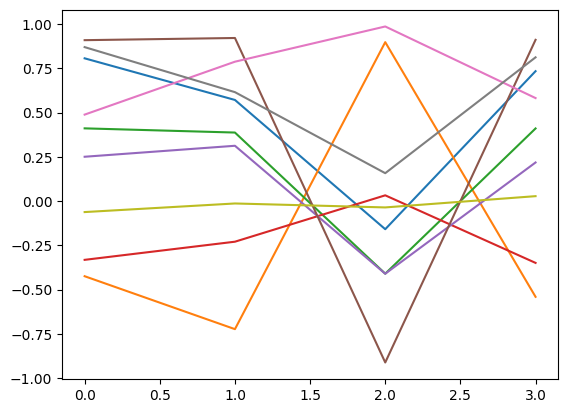

In [113]:
hist = np.array(Vt_hist)
plt.plot(hist[:, 0])
plt.plot(hist[:, 1])
plt.plot(hist[:, 2])

In [114]:
def compute_angles(mats):
    angles = []
    for i in range(len(mats)-1):
        m1 = mats[i]
        m2 = mats[i+1]
        #v1 = vectors[i-1]
        #v2 = vectors[i]
        #cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        #angle = np.arccos(np.clip(cos_angle, -1, 1))  # avoid floating point errors
        #angles.append(np.degrees(angle))
        rel_rot_mat = np.dot(m1.T,m2)
        euler = Rotation.from_matrix(rel_rot_mat).as_euler('xyz', degrees=True)
        '''
        torsion = []
        for j in range(3):
            v1 = rel_rot_mat[:,j]
            v2 = rel_rot_mat[:,j]
            theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            torsion.append(theta)
        '''
        print(f"{i}, {euler}")
        #angles.append(torsion)
    return angles
compute_angles(Vt_hist)

0, [-2.91667274  1.2553045  22.68594305]
1, [-178.16888186    2.52826113   47.16299569]
2, [-179.63289092    0.20715465   63.46543867]


[]

In [115]:
for i in range(len(repeats) - 1):
    print(f"start: {repeats[i][0]} end: {repeats[i][1]}")
    x = CA_pos[repeats[1][0]:repeats[1][1]+1,:] # compare to constant refrence
    #x = CA_pos[repeats[i][0]:repeats[i][1]+1,:] # compare consecuitive units
    y = CA_pos[repeats[i+1][0]:repeats[i+1][1]+1,:]
    min_len = min(x.shape[0], y.shape[0])
    sup.set(x[0:min_len,:],y[0:min_len,:])
    sup.run()
    rot, tran = sup.get_rotran()
    print(Rotation.from_matrix(rot).as_euler('xyz', degrees=True))
    print(sup.get_rms())

start: 3 end: 19
[-1.59870024e-14  1.27222187e-14 -5.75457525e-15]
3.891802844472395e-15
start: 20 end: 34
[ 1.06280744 -4.89717309  0.78561461]
1.4203850721033882
start: 35 end: 49
[14.73979122 15.03928242  9.82099042]
3.4974013890777575
